In [1]:
include("random_clifford/Initial.jl")
include("random_clifford/Symplectic.jl")

reverseCommands (generic function with 1 method)

In [2]:
using Yao
using YaoBlocks
using Random
using PyPlot
using YaoSym
using YaoExtensions
using QuAlgorithmZoo: Adam, update!
using LinearAlgebra

## Generate a dataset of random clifford circuit and corresponding energy

### Parameters

In [3]:
n_qubits = 5
n_circuits = 100
n = n_qubits;

### Create random circuits

In [4]:
n_clifford_circuits = max(getNumberOfSymplecticCliffords(n), 2^63-1)

9223372036854775807

In [5]:
function parseCommand(command)
    if command[1] == "hadamard"
        return put(command[2]=>H)
    elseif command[1] == "phase"
        return put(command[2]=>shift(π/2))
    elseif command[1] == "cnot"
        return control(command[2][1], command[2][2]=>X)
    else
        error("The command should be either 'hadamard', 'phase' or 'cnot', not $(command[1])")
    end
end

parseCommand (generic function with 1 method)

In [6]:
function getRandomCircuit(i)
    commands = decompose(rand(0:n_clifford_circuits), rand(0:2^(2*n)), n, true)
    list_commands = map(c -> (c[1], parse.(Int, split(c[2], ","))),
                    split.(commands, r"\(|\)", keepempty=false)[2:length(commands)-1])
    circuit = chain(n_qubits, parseCommand.(list_commands))
    print("$(i) ")
    return circuit
end

getRandomCircuit (generic function with 1 method)

In [33]:
list_circuits = [getRandomCircuit(i) for i in 1:n_circuits];

1 2 3 

InterruptException: InterruptException:

In [34]:
list_circuits

100-element Array{ChainBlock{5},1}:
 nqubits: 5
chain
├─ control(5)
│  └─ (1,) X gate
├─ control(4)
│  └─ (3,) X gate
├─ control(3)
│  └─ (2,) X gate
├─ control(3)
│  └─ (1,) X gate
├─ put on (3)
│  └─ shift(1.5707963267948966)
├─ put on (3)
│  └─ shift(1.5707963267948966)
├─ put on (2)
│  └─ shift(1.5707963267948966)
├─ put on (2)
│  └─ shift(1.5707963267948966)
├─ put on (3)
│  └─ shift(1.5707963267948966)
├─ put on (2)
│  └─ shift(1.5707963267948966)
├─ put on (1)
│  └─ shift(1.5707963267948966)
├─ control(4)
│  └─ (3,) X gate
├─ control(4)
│  └─ (2,) X gate
├─ control(3)
│  └─ (2,) X gate
├─ control(5)
│  └─ (1,) X gate
├─ control(4)
│  └─ (1,) X gate
├─ control(3)
│  └─ (1,) X gate
├─ put on (1)
│  └─ shift(1.5707963267948966)
├─ put on (5)
│  └─ H gate
├─ put on (4)
│  └─ H gate
├─ put on (3)
│  └─ H gate
├─ put on (2)
│  └─ H gate
├─ put on (1)
│  └─ H gate
├─ control(5)
│  └─ (4,) X gate
├─ control(4)
│  └─ (2,) X gate
├─ control(3)
│  └─ (2,) X gate
├─ control(3)
│  └─ (1,) X 

In [8]:
ket"00000" |> list_circuits[17]

NotImplementedError{Tuple{DataType,ShiftGate{Float64}}}: NotImplementedError: mat is not implemented for (::DataType, ::ShiftGate{Float64}), please implement this method for your custom type

### Create Hamiltonian

In [9]:
W = 1/n * (UnitUpperTriangular(ones(n, n)) - I)

5×5 UpperTriangular{Float64,Array{Float64,2}}:
 0.0  0.2  0.2  0.2  0.2
  ⋅   0.0  0.2  0.2  0.2
  ⋅    ⋅   0.0  0.2  0.2
  ⋅    ⋅    ⋅   0.0  0.2
  ⋅    ⋅    ⋅    ⋅   0.0

In [10]:
function get_hamiltonian(W::AbstractMatrix)
    nbit = size(W, 1)
    ab = Any[]
    for i=1:nbit,j=i+1:nbit
        if W[i,j] != 0
            push!(ab, 0.5*W[i,j]*repeat(nbit, Z, [i,j]))
        end
    end
    sum(ab)
end

get_hamiltonian (generic function with 1 method)

In [11]:
hamil = get_hamiltonian(W);

In [12]:
function evaluate_hamiltonian(i)
    print(i);
    print(" ")
    expect(hamil, zero_state(n_qubits) |> list_circuits[i])
end

evaluate_hamiltonian (generic function with 1 method)

### Compute the expectation values

In [13]:
state = zero_state(n_qubits) |> list_circuits[1];

In [14]:
energies = evaluate_hamiltonian.(1:n_circuits);

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

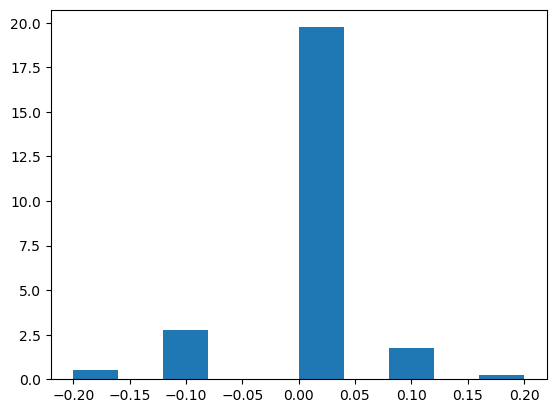

In [15]:
hist(energies, normed=true);

### TODO: create a balanced dataset (in terms of energy)

### TODO: Save the dataset

## Variational circuit

### Definition

In [27]:
v_unitary = variational_circuit(n);
dispatch!.(v_unitary, :random);
v_circuit = chain(n+1, put(1=>H), control(1, 2:n+1=>v_unitary), put(1=>H));
total_circuits = [chain(n+1, concentrate(n+1, circuit, 2:n+1), v_circuit) for circuit in list_circuits];
grad_input, grad_params = expect'(put(n+1, 1=>Z), zero_state(n+1) => total_circuits[1]);

In [28]:
parameters(v_unitary)

50-element Array{Float64,1}:
 0.022592684188605494
 0.4557297851191493  
 0.6965395172911117  
 0.517580064769954   
 0.7727594243515254  
 0.1803519924712893  
 0.9989435728708302  
 0.662610900909453   
 0.323315854188299   
 0.10054822238411276 
 0.053506549896398026
 0.6394867909413853  
 0.10344555903569219 
 ⋮                   
 0.3475154209462925  
 0.4086085733534228  
 0.7184867635766721  
 0.3345721252590188  
 0.21143729277816004 
 0.3885892299866369  
 0.5840991871880594  
 0.9318412655296355  
 0.9339007228463132  
 0.14993515295394455 
 0.8247920466223173  
 0.5685724708947324  

In [29]:
function loss(real_energy, predicted_energy)
    return 1/2 * (real_energy - predicted_energy)^2
end

loss (generic function with 1 method)

In [30]:
expect(put(n+1, 1=>Z), zero_state(n+1) |> total_circuits[1])

0.9999999999999991 + 0.0im

In [32]:
optimizer = Adam(lr=0.01)
niter = 100

for i = 1:niter
    params = parameters(total_circuits[1])
    psi = zero_state(n+1) |> total_circuits[1]
    Z1 = put(n+1, 1=>Z)
    grad_input, grad_params = expect'(Z1, zero_state(n+1) => total_circuits[1])
#     grad_input *= expect(put(n+1, 1=>Z), psi) - energies[i]
    print(length(grad_params))
    dispatch!(v_unitary, update!(params, grad_params, optimizer))
    break
#     ## feed the gradients into the circuit.
#     
#     println("Step $i, Energy = $(expect(hami, zero_state(N) |> c))")
#     "$(expect(1=>Z, zero_state(n+1) => total_circuits[i]))"
end

22

BoundsError: BoundsError: attempt to access 22-element Array{Float64,1} at index [23:23]

In [21]:
psi = zero_state(n+1) |> total_circuits[1]
Z1 = put(n+1, 1=>Z)
grad_input, grad_params = expect'(Z1, zero_state(n+1) => total_circuits[1])[2]

MethodError: MethodError: no method matching dynamicize(::Array{Int64,1})
Closest candidates are:
  dynamicize(!Matched::StaticArrays.SArray{Tuple{S1,S2},T,2,L} where L where T where S2 where S1) at /Users/arthurpesah/.julia/packages/LuxurySparse/lU2dS/src/staticize.jl:42
  dynamicize(!Matched::StaticArrays.SArray{Tuple{S},T,1,S} where T where S) at /Users/arthurpesah/.julia/packages/LuxurySparse/lU2dS/src/staticize.jl:43
  dynamicize(!Matched::Diagonal{T,StaticArrays.SArray{Tuple{N},T,1,N}} where T where N) at /Users/arthurpesah/.julia/packages/LuxurySparse/lU2dS/src/staticize.jl:44
  ...

In [22]:
dispatch!(v_unitary, update!(params, grad_params, optimizer))

UndefVarError: UndefVarError: params not defined

In [23]:
v_unitary = variational_circuit(n);
dispatch!.(v_unitary, :random);
v_circuit = chain(n+1, put(1=>H), control(1, 2:n+1=>v_unitary), put(1=>H));
total_circuits = chain(n+1, concentrate(n+1, list_circuits[1], 2:n+1), v_circuit);
grad_input, grad_params = expect'(put(n+1, 1=>Z), zero_state(n+1) => total_circuits[1]);

params = parameters(total_circuits[1])
psi = zero_state(n+1) |> total_circuits[i]
Z1 = put(n+1, 1=>Z)
grad_input, grad_params = expect'(Z1, zero_state(n+1) => total_circuits[i])
dispatch!(v_unitary, update!(params, grad_params, optimizer))

UndefVarError: UndefVarError: i not defined